library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(lme4) #random effect

In [1]:
#install.packages("rptR")
library(rptR)
library(ggplot2)

library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(lme4) #random effect

library(DHARMa) #verify assumpltion of glm

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.6     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


This is DHARMa 0.3.3.0. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa') Note: Syntax of plotResiduals has changed in 0.3.0, see ?plotResiduals f

#install.packages("emmeans")
library(DHARMa)
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(modEvA)
library(dplyr)
library(lme4) #random effect
library(broom)
library(ggpubr) 
library(rstatix)
library(WRS2) #robust ancova
library(lmerTest) #like lmer but with p-value
library(emmeans)

#levenetest
library(car)

In [2]:
#TODO: nboot change to 500????
#find out the which one to use: link or org
#find out about undary (singular) fit: see ?isSingular

# Download data

In [3]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/correctlightschedule_'
path_model = file.path(path_,'repeatability_model_twodays')
df = read.csv(file.path(path_,'df_MVT_4repeatibility.csv'), header = TRUE, sep = ";")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$TrackingSystemID = as.factor(df$TrackingSystemID) 
#li_var_cont = c('ID0','ID1','ID2','ID3','ID4','ID5','ID6','ID7')
#df$maxsevGap0_divided_maxsev_round = round(df$maxsevGap0_divided_maxsev, 1)
#df$maxsevGap0_divided_maxsev_round_log <- log(df$maxsevGap0_divided_maxsev_round)
#print(as.data.frame(table(df$maxsevGap0_divided_maxsev_round)))
#df_ = df[,c(li_var_cont, 'maxsevGap0_divided_maxsev_round','maxsevGap0_divided_maxsev_round_log')] 
print(dim(df))
summary(df)

[1] 6382  228


     HenID         level           duration_1_Zone duration_2_Zone
 hen_10 :  51   Length:6382        Min.   :    0   Min.   :    0  
 hen_108:  51   Class :character   1st Qu.:    0   1st Qu.: 5200  
 hen_111:  51   Mode  :character   Median :    0   Median :14214  
 hen_112:  51                      Mean   : 1244   Mean   :14054  
 hen_117:  51                      3rd Qu.: 1680   3rd Qu.:21776  
 hen_118:  51                      Max.   :18997   Max.   :43644  
 (Other):6076                                                     
 duration_3_Zone duration_4_Zone duration_5_Zone
 Min.   :    0   Min.   :    0   Min.   :    0  
 1st Qu.: 2442   1st Qu.: 1372   1st Qu.: 5394  
 Median : 6553   Median : 2844   Median :14859  
 Mean   : 7809   Mean   : 3492   Mean   :17597  
 3rd Qu.:11929   3rd Qu.: 4517   3rd Qu.:29404  
 Max.   :34417   Max.   :44088   Max.   :52195  
                                                
 verification_daily_total_duration Total_number_zone Max_duration_zones


In [4]:
li_mvt4MLPs = c('perc_duration_5_Zone','perc_duration_4_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'vertical_travel_distance_perh')
#'percentage_time_outside_while_WG_open', 'latency_1_Zone', 

# Repeatability within 2 days depending on the number of days in between

In [5]:
li_R_org = c()
li_R_link = c()
li_CIL_org = c()
li_CIU_org = c()
li_CIL_link = c()
li_CIU_link = c()
li_P = c()
li_se_link = c()
li_se_org = c() 
li_ngroup = c()
li_nobs = c()
li_mod = c()
li_var = c()
li_dib = c()
li_nbrdays = c()
`%notin%` = Negate(`%in%`)
nb = 10 
for (i in 1:21){
    for (j in 1:32){
        if ((i %notin% c(4,6,9,10)) & ((i+j) %notin% c(4,6,9,10))){
            df_ = df[ which(df$DIB==i | df$DIB==(i+j)), ]   
            #perc_duration_5_Zone
            df_$Y = df_$perc_duration_5_Zone
            model_ = rpt(Y ~  PenID + (1|HenID), grname = c("HenID"), data = df_, datatype = "Gaussian", 
                         nboot = nb, npermut = 0)
            li_R_org = append(li_R_org, model_$R[[1]])
            li_CIL_org = append(li_CIL_org, model_$CI_emp[,'2.5%'])
            li_CIU_org = append(li_CIU_org, model_$CI_emp[,'97.5%'])
            li_P = append(li_P, model_$P$LRT_P)
            li_se_org = append(li_se_org, model_$se[[1]])
            li_ngroup = append(li_ngroup, model_$ngroups[['HenID']])
            li_nobs = append(li_nobs, model_$nobs)
            li_mod = append(li_mod, model_$mod)
            li_var = append(li_var, 'perc_duration_5_Zone')
            li_nbrdays = append(li_nbrdays,j)
            li_dib = append(li_dib, i)
            #save model assumption verification 
            name = 'perc_duration_5_Zone'
            ###### histogram of dep var 
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model,paste0(name,'_Histrogram_',j,'-',i,'.jpg')))
            hist(df_$Y)
            dev.off()
            ###### normally distributed residuals
            jpeg(file.path(path_model, paste(name,'_diagnostic_normally_distributed_residual_',j,'-',i,'.jpg', sep='')))
            qqnorm(resid(model_$mod), main = "Residuals")
            qqline(resid(model_$mod))
            dev.off()
            ######check homogeneity of variance (residuals has constant variance)
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model, paste(name,'_diagnostic_homogeneity_variance_',j,'-',i,'.jpg', sep='')))
            plot(model_$mod)
            dev.off()

            #perc_duration_3_Zone
            df_$Y = df_$perc_duration_3_Zone
            model_ = rpt(Y ~  PenID + (1|HenID) , grname = c("HenID"), data = df_, datatype = "Gaussian", 
                         nboot = nb, npermut = 0)
            li_R_org = append(li_R_org, model_$R[[1]])
            li_CIL_org = append(li_CIL_org, model_$CI_emp[,'2.5%'])
            li_CIU_org = append(li_CIU_org, model_$CI_emp[,'97.5%'])
            li_P = append(li_P, model_$P$LRT_P)
            li_se_org = append(li_se_org, model_$se[[1]])
            li_ngroup = append(li_ngroup, model_$ngroups[['HenID']])
            li_nobs = append(li_nobs, model_$nobs)
            li_mod = append(li_mod, model_$mod)
            li_var = append(li_var, 'perc_duration_3_Zone')
            li_nbrdays = append(li_nbrdays,j)
            li_dib = append(li_dib, i)
            #save model assumption verification 
            name = 'perc_duration_3_Zone'
            ###### histogram of dep var 
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model,paste0(name,'_Histrogram_',j,'-',i,'.jpg')))
            hist(df_$Y)
            dev.off()
            ######linearity of predictors: plot residual vs observed
            jpeg(file.path(path_model, paste(name,'_diagnostic_predictors_linearity_',j,'-',i,'.jpg', sep='')))
            plot(resid(model_$mod),df_$Y)
            dev.off()
            ###### normally distributed residuals
            jpeg(file.path(path_model, paste(name,'_diagnostic_normally_distributed_residual_',j,'-',i,'.jpg', sep='')))
            qqnorm(resid(model_$mod), main = "Residuals")
            qqline(resid(model_$mod))
            dev.off()
            jpeg(file.path(path_model, paste(name,'_diagnostic_normally_distributed_residual_histogram_',j,'-',i,'.jpg', sep='')))
            hist(resid(model_$mod))
            dev.off()

            #perc_duration_2_Zone
            df_$Y = df_$perc_duration_2_Zone
            model_ = rpt(Y ~ PenID + (1|HenID), grname = c("HenID"), data = df_, datatype = "Gaussian", 
                         nboot = nb, npermut = 0)
            li_R_org = append(li_R_org, model_$R[[1]])
            li_CIL_org = append(li_CIL_org, model_$CI_emp[,'2.5%'])
            li_CIU_org = append(li_CIU_org, model_$CI_emp[,'97.5%'])
            li_P = append(li_P, model_$P$LRT_P)
            li_se_org = append(li_se_org, model_$se[[1]])
            li_ngroup = append(li_ngroup, model_$ngroups[['HenID']])
            li_nobs = append(li_nobs, model_$nobs)
            li_mod = append(li_mod, model_$mod)
            li_var = append(li_var, 'perc_duration_2_Zone')
            li_nbrdays = append(li_nbrdays,j)
            li_dib = append(li_dib, i)
            #save model assumption verification 
            name = 'perc_duration_2_Zone'
            ###### histogram of dep var 
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model,paste0(name,'_Histrogram_',j,'-',i,'.jpg')))
            hist(df_$Y)
            dev.off()
            ###### normally distributed residuals
            jpeg(file.path(path_model, paste(name,'_diagnostic_normally_distributed_residual_',j,'-',i,'.jpg', sep='')))
            qqnorm(resid(model_$mod), main = "Residuals")
            qqline(resid(model_$mod))
            dev.off()
            ######check homogeneity of variance (residuals has constant variance)
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model, paste(name,'_diagnostic_homogeneity_variance_',j,'-',i,'.jpg', sep='')))
            plot(model_$mod)
            dev.off()
            
            #vertical_travel_distance_perh
            df_$Y = df_$vertical_travel_distance_perh
            model_ = rpt(vertical_travel_distance_perh ~ PenID +  (1|HenID) , grname = c("HenID"), data = df_, datatype = "Gaussian", 
                         nboot = nb, npermut = 0)
            li_R_org = append(li_R_org, model_$R[[1]])
            li_CIL_org = append(li_CIL_org, model_$CI_emp[,'2.5%'])
            li_CIU_org = append(li_CIU_org, model_$CI_emp[,'97.5%'])
            li_P = append(li_P, model_$P$LRT_P)
            li_se_org = append(li_se_org, model_$se[[1]])
            li_ngroup = append(li_ngroup, model_$ngroups[['HenID']])
            li_nobs = append(li_nobs, model_$nobs)
            li_mod = append(li_mod, model_$mod)
            li_var = append(li_var, 'vertical_travel_distance_perh')
            li_nbrdays = append(li_nbrdays,j)
            li_dib = append(li_dib, i)
            #save model assumption verification 
            name = 'vertical_travel_distance_perh'
            ###### histogram of dep var 
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model,paste0(name,'_Histrogram_',j,'-',i,'.jpg')))
            hist(df_$Y)
            dev.off()
            ###### normally distributed residuals
            jpeg(file.path(path_model, paste(name,'_diagnostic_normally_distributed_residual_',j,'-',i,'.jpg', sep='')))
            qqnorm(resid(model_$mod), main = "Residuals")
            qqline(resid(model_$mod))
            dev.off()
            ######check homogeneity of variance (residuals has constant variance)
            #variance of the residuals is equal across groups. Even spread around the centered line?
            jpeg(file.path(path_model, paste(name,'_diagnostic_homogeneity_variance_',j,'-',i,'.jpg', sep='')))
            plot(model_$mod)
            dev.off()

}}}
df_res = data.frame(li_R_org, li_CIL_org, li_CIU_org, li_P, li_se_org, 
                    li_ngroup, li_nobs, li_var, li_dib, li_nbrdays)
#save
write.csv(df_res, file.path(path_,'df_MVT_repeatibility_DIB&Xdaysinbetween.csv'), sep=';')
df_res

Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular



Bootstrap Progress:
Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Bootstrap Progress:


ERROR: Error in data.frame(li_R_org, li_CIL_org, li_CIU_org, li_CIU_link, li_P, : arguments imply differing number of rows: 2100, 0


In [8]:
df_res

li_R_org    li_CIL_org   li_CIU_org li_P         li_se_org  li_ngroup
1    0.61644368  0.574921794  0.7066795  1.592797e-14 0.04583929 131      
2    0.32394356  0.189443358  0.4297383  2.708594e-04 0.08273106 131      
3    0.75563429  0.685128300  0.8119609  7.180427e-25 0.04251475 131      
4    0.56774000  0.505514841  0.6456241  4.885612e-12 0.05407463 131      
5    0.51302237  0.436777044  0.5801168  1.053021e-09 0.06016709 131      
6    0.42829448  0.291579819  0.5736484  7.614469e-07 0.09997758 131      
7    0.55309265  0.498371664  0.6677083  2.275739e-11 0.05879311 131      
8    0.53613984  0.481835346  0.6670907  1.228974e-10 0.06680733 131      
9    0.40662715  0.266865520  0.4913014  2.191535e-05 0.08520271 131      
10   0.34987816  0.275896433  0.4748735  2.153166e-04 0.06678024 131      
11   0.53862983  0.464998173  0.6827190  2.459505e-08 0.06970993 131      
12   0.43602295  0.368187184  0.5762035  4.981912e-06 0.06882859 131      
13   0.19536723  0.063713627  0.3864678  2.870191e-02 0.10358893 131      
14   0.11060243  0.053222419  0.2701353  1.814072e-01 0.07104468 131      
15   0.24852411  0.197483020  0.4641138  5.632869e-03 0.08971583 131      
16   0.44832829  0.378791811  0.5888788  1.894004e-07 0.07164986 131      
17   0.12809082  0.083215113  0.2978712  1.329230e-01 0.08126027 131      
18   0.05566230  0.000000000  0.2354843  3.908432e-01 0.09756457 131      
19   0.21806308  0.213295425  0.3583686  1.502368e-02 0.04941225 131      
20   0.41512743  0.342501472  0.5520628  1.807029e-06 0.06869623 131      
21   0.22972266  0.151572235  0.4701352  1.048216e-02 0.10813071 131      
22   0.03274883  0.006053237  0.1977894  4.942726e-01 0.06617492 131      
23   0.20877235  0.011713272  0.3243849  1.974727e-02 0.11452798 131      
24   0.21938787  0.032341564  0.3838258  1.443536e-02 0.11289123 131      
25   0.24320303  0.117286327  0.4733814  2.462405e-02 0.12505178 131      
26   0.38623001  0.276496263  0.4962586  8.938236e-03 0.07951654 131      
27   0.13145696  0.000000000  0.3668135  1.951345e-01 0.12395829 131      
28   0.22518076  0.048607085  0.4262438  1.715396e-02 0.12594349 131      
29   0.18455197  0.035016489  0.4344884  7.825668e-02 0.12712099 131      
30   0.35495847  0.266849293  0.5288873  2.113433e-02 0.08557263 131      
...  ...         ...          ...        ...          ...        ...      
2071 0.001291086 0.000000e+00 0.09690275 1.0000000000 0.03911992 131      
2072 0.312808443 2.523600e-01 0.42925943 0.0004479897 0.06251548 131      
2073 0.047482546 5.563241e-19 0.15040379 0.4284487388 0.05424399 131      
2074 0.000000000 0.000000e+00 0.14025258 1.0000000000 0.05214375 131      
2075 0.012029378 0.000000e+00 0.16294340 1.0000000000 0.06274229 131      
2076 0.291303010 1.801595e-01 0.50457819 0.0011309902 0.10699109 131      
2077 0.092919511 0.000000e+00 0.21623448 0.2415893617 0.08093675 131      
2078 0.000000000 0.000000e+00 0.17311809 0.4999997310 0.05878550 131      
2079 0.060454147 0.000000e+00 0.19530407 0.3697121306 0.07474537 131      
2080 0.267711847 2.201203e-01 0.45629166 0.0028426866 0.07830052 131      
2081 0.044506430 1.618095e-04 0.18250031 0.4410787254 0.06527175 131      
2082 0.000000000 0.000000e+00 0.07033604 1.0000000000 0.02567845 131      
2083 0.085456771 4.951468e-15 0.18270610 0.2672441476 0.06876440 131      
2084 0.258914510 1.393677e-01 0.35256333 0.0039148754 0.08496450 131      
2085 0.024990684 0.000000e+00 0.16329447 1.0000000000 0.06857136 131      
2086 0.000000000 0.000000e+00 0.19099048 1.0000000000 0.07162560 131      
2087 0.068413151 6.514104e-04 0.16168029 0.3359184552 0.06462068 131      
2088 0.248060826 6.354068e-02 0.40291355 0.0057536272 0.10709754 131      
2089 0.075928679 1.571713e-02 0.23667026 0.3070301071 0.08009373 131      
2090 0.031983188 1.418988e-18 0.21989821 1.0000000000 0.07484522 131      
2091 0.115585675 6.957432e-03 0.33983226 0.1684000631 0.11673556 131      
2092 0.247555188 1.914546e-01 

In [10]:
p = ggplot(df_res[ which(df_res$li_var=='vertical_travel_distance_perh'), ] , aes(x=li_nbrdays, y=li_R_org, group=li_dib, color=li_dib, position='fill')) +
  geom_point(size=2.5, position = position_dodge(width=1)) +
  geom_errorbar(aes(ymax = li_CIU_org, ymin = li_CIL_org), position = position_dodge(width=1)) +
  theme(aspect.ratio = 0.8)
p + ggtitle("Vertical travel distance per hour") +
  xlab("number of days") + ylab("repeatability")+ coord_cartesian(ylim = c(0, 1))
ggsave(file.path(path_,'repeatability_vertical_travel_distance_perh_org.png'))

Saving 6.67 x 6.67 in image



In [11]:
p = ggplot(df_res[ which(df_res$li_var=='perc_duration_5_Zone'), ] , aes(x=li_nbrdays, y=li_R_org, group=li_dib, color=li_dib, position='fill')) +
  geom_point(size=2.5, position = position_dodge(width=1)) +
  geom_errorbar(aes(ymax = li_CIU_org, ymin = li_CIL_org), position = position_dodge(width=1)) +
  theme(aspect.ratio = 0.8)
p + ggtitle("Percentage of duration in zone 5") +
  xlab("number of days") + ylab("repeatability")+ coord_cartesian(ylim = c(0, 1))
ggsave(file.path(path_,'repeatability_perc_duration_5_Zone_org.png'))

Saving 6.67 x 6.67 in image



Saving 6.67 x 6.67 in image



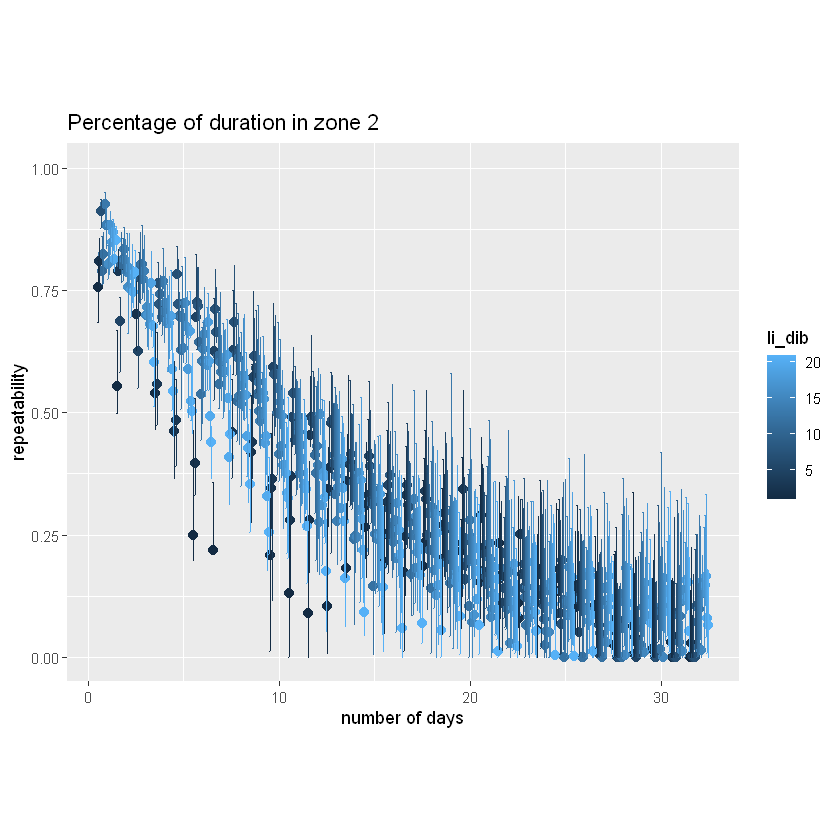

In [12]:
p = ggplot(df_res[ which(df_res$li_var=='perc_duration_2_Zone'), ] , aes(x=li_nbrdays, y=li_R_org, group=li_dib, color=li_dib, position='fill')) +
  geom_point(size=2.5, position = position_dodge(width=1)) +
  geom_errorbar(aes(ymax = li_CIU_org, ymin = li_CIL_org), position = position_dodge(width=1)) +
  theme(aspect.ratio = 0.8)
p + ggtitle("Percentage of duration in zone 2") +
  xlab("number of days") + ylab("repeatability")+ coord_cartesian(ylim = c(0, 1))
ggsave(file.path(path_,'repeatability_perc_duration_2_Zone_org.png'))

Saving 6.67 x 6.67 in image



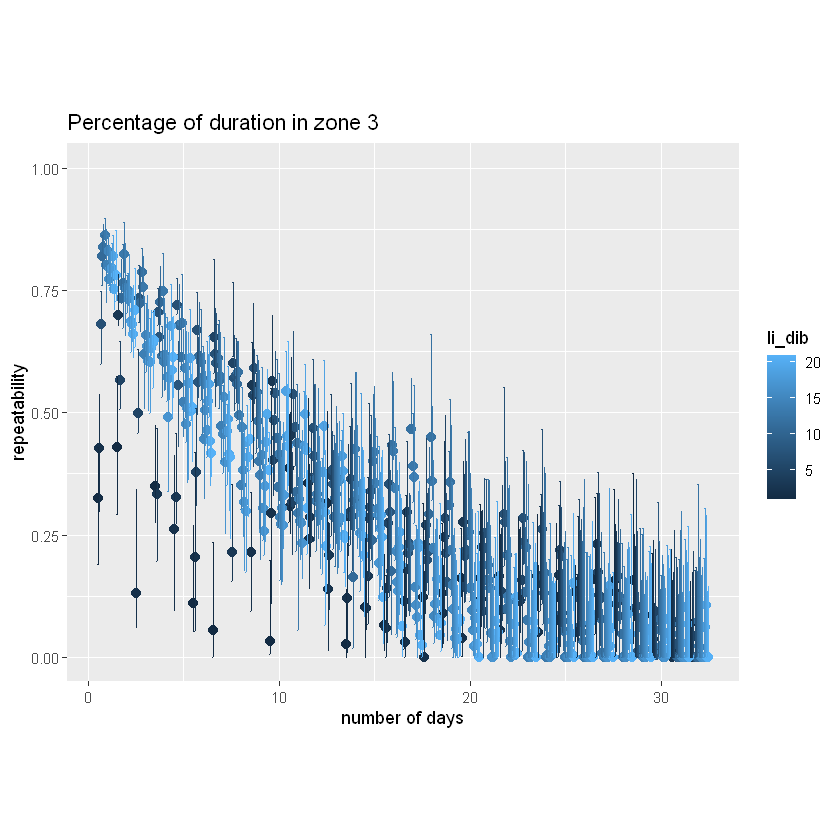

In [13]:
p = ggplot(df_res[ which(df_res$li_var=='perc_duration_3_Zone'), ] , aes(x=li_nbrdays, y=li_R_org, group=li_dib, color=li_dib, position='fill')) +
  geom_point(size=2.5, position = position_dodge(width=1)) +
  geom_errorbar(aes(ymax = li_CIU_org, ymin = li_CIL_org), position = position_dodge(width=1)) +
  theme(aspect.ratio = 0.8)
p + ggtitle("Percentage of duration in zone 3") +
  xlab("number of days") + ylab("repeatability")+ coord_cartesian(ylim = c(0, 1))
ggsave(file.path(path_,'repeatability_perc_duration_3_Zone_org.png'))